# Plotting the CNN architecture

We will generate a figure using a public GitHub repository: https://github.com/yu4u/convnet-drawer

This repo will allow us to generate a nice figure of CNN architectures using Keras. Please see it's [README](https://github.com/yu4u/convnet-drawer/blob/master/README.md) file to learn how to use it.

Let's import our code from the repo:

In [1]:
import math

theta = - math.pi / 6
ratio = 0.5
bounding_box_margin = 20
inter_layer_margin = 40
text_margin = 9
channel_scale = 4 / 5
text_size = 8
one_dim_width = 8
line_color_feature_map = (0, 0, 0)
line_color_layer = (0, 0, 255)
text_color_feature_map = (0, 0, 0)
text_color_layer = (0, 0, 0)

In [2]:
import math
from abc import ABCMeta, abstractmethod


class Line:
    def __init__(self, x1, y1, x2, y2, color=(0, 0, 0), width=1, dasharray=None):
        self.x1, self.y1 = x1, y1
        self.x2, self.y2 = x2, y2
        self.color = color
        self.width = width
        self.dasharray = dasharray

    def get_svg_string(self):
        stroke_dasharray = self.dasharray if self.dasharray else "none"
        return '<line x1="{}" y1="{}" x2="{}" y2="{}" stroke-width="{}" stroke-dasharray="{}" stroke="rgb{}"/>\n'.format(
            self.x1, self.y1, self.x2, self.y2, self.width, stroke_dasharray, self.color)


class Text:
    def __init__(self, x, y, body, color=(0, 0, 0), size=20):
        self.x = x
        self.y = y
        self.body = body
        self.color = color
        self.size = size

    def get_svg_string(self):
        return '<text x="{}" y="{}" font-family="arial" font-size="{}px" ' \
               'text-anchor="middle" fill="rgb{}">{}</text>\n'.format(self.x, self.y, self.size, self.color, self.body)


class Model:
    def __init__(self, input_shape):
        self.layers = []

        if len(input_shape) != 3:
            raise ValueError("input_shape should be rank 3 but received  {}".format(input_shape))

        self.feature_maps = []
        self.x = None
        self.y = None
        self.width = None
        self.height = None

        self.feature_maps.append(FeatureMap3D(*input_shape))

    def add_feature_map(self, layer):
        if isinstance(self.feature_maps[-1], FeatureMap3D):
            h, w = self.feature_maps[-1].h, self.feature_maps[-1].w
            filters = layer.filters if layer.filters else self.feature_maps[-1].c

            if isinstance(layer, GlobalAveragePooling2D):
                self.feature_maps.append(FeatureMap1D(filters))
            elif isinstance(layer, Flatten):
                self.feature_maps.append(FeatureMap1D(h * w * filters))
            else:
                if layer.padding == "same":
                    new_h = math.ceil(h / layer.strides[0])
                    new_w = math.ceil(w / layer.strides[1])
                else:
                    new_h = math.ceil((h - layer.kernel_size[0] + 1) / layer.strides[0])
                    new_w = math.ceil((w - layer.kernel_size[1] + 1) / layer.strides[1])

                self.feature_maps.append(FeatureMap3D(new_h, new_w, filters))
        else:
            self.feature_maps.append(FeatureMap1D(layer.filters))

    def add(self, layer):
        self.add_feature_map(layer)
        layer.prev_feature_map = self.feature_maps[-2]
        layer.next_feature_map = self.feature_maps[-1]
        self.layers.append(layer)

    def build(self):
        left = 0

        for feature_map in self.feature_maps:
            right = feature_map.set_objects(left)
            left = right + inter_layer_margin

        for i, layer in enumerate(self.layers):
            layer.set_objects()

        # get bounding box
        self.x = - bounding_box_margin - 30
        self.y = min([f.get_top() for f in self.feature_maps]) - text_margin - text_size \
            - bounding_box_margin
        self.width = self.feature_maps[-1].right + bounding_box_margin * 2 + 30 * 2
        # TODO: automatically calculate the ad-hoc offset "30" from description length
        self.height = - self.y * 2 + text_size

    def save_fig(self, filename):
        self.build()
        string = '<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" ' \
                 'width= "{}" height="{}" '.format(self.width, self.height) + \
                 'viewBox="{} {} {} {}">\n'.format(self.x, self.y, self.width, self.height)

        for feature_map in self.feature_maps:
            string += feature_map.get_object_string()

        for layer in self.layers:
            string += layer.get_object_string()

        string += '</svg>'
        f = open(filename, 'w')
        f.write(string)
        f.close()


class FeatureMap:
    __metaclass__ = ABCMeta

    def __init__(self):
        self.left = None
        self.right = None
        self.objects = None

    @abstractmethod
    def set_objects(self, left):
        pass

    def get_object_string(self):
        return get_object_string(self.objects)

    @abstractmethod
    def get_top(self):
        pass

    @abstractmethod
    def get_bottom(self):
        pass


class FeatureMap3D(FeatureMap):
    def __init__(self, h, w, c):
        self.h = h
        self.w = w
        self.c = c
        super(FeatureMap3D, self).__init__()

    def set_objects(self, left):
        self.left = left
        c_ = math.pow(self.c, channel_scale)
        self.right, self.objects = get_rectangular(self.h, self.w, c_, left, line_color_feature_map)
        x = (left + self.right) / 2
        y = self.get_top() - text_margin
        self.objects.append(Text(x, y, "{}x{}x{}".format(self.h, self.w, self.c), color=text_color_feature_map,
                                 size=text_size))

        return self.right

    def get_left_for_conv(self):
        return self.left + self.w * ratio * math.cos(theta) / 2

    def get_top(self):
        return - self.h / 2 + self.w * ratio * math.sin(theta) / 2

    def get_bottom(self):
        return self.h / 2 - self.w * ratio * math.sin(theta) / 2

    def get_right_for_conv(self):
        x = self.left + self.w * ratio * math.cos(theta) / 4
        y = - self.h / 4 + self.w * ratio * math.sin(theta) / 4

        return x, y


class FeatureMap1D(FeatureMap):
    def __init__(self, c):
        self.c = c
        super(FeatureMap1D, self).__init__()

    def set_objects(self, left):
        self.left = left
        c_ = math.pow(self.c, channel_scale)
        self.right = left + one_dim_width
        # TODO: reflect text length to right
        x1 = left
        y1 = - c_ / 2
        x2 = left + one_dim_width
        y2 = c_ / 2
        line_color = line_color_feature_map
        self.objects = []
        self.objects.append(Line(x1, y1, x1, y2, line_color))
        self.objects.append(Line(x1, y2, x2, y2, line_color))
        self.objects.append(Line(x2, y2, x2, y1, line_color))
        self.objects.append(Line(x2, y1, x1, y1, line_color))
        self.objects.append(Text(left + one_dim_width / 2, - c_ / 2 - text_margin, "{}".format(
            self.c), color=text_color_feature_map, size=text_size))

        return self.right

    def get_top(self):
        return - math.pow(self.c, channel_scale) / 2

    def get_bottom(self):
        return math.pow(self.c, channel_scale) / 2


class Layer:
    __metaclass__ = ABCMeta

    def __init__(self, filters=None, kernel_size=None, strides=(1, 1), padding="valid"):
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.objects = []
        self.prev_feature_map = None
        self.next_feature_map = None
        self.description = None

    @abstractmethod
    def get_description(self):
        return None

    def set_objects(self):
        c = math.pow(self.prev_feature_map.c, channel_scale)
        left = self.prev_feature_map.get_left_for_conv()
        start1 = (left + c,
                  -self.kernel_size[0] + self.kernel_size[1] * ratio * math.sin(theta) / 2
                  + self.kernel_size[0] / 2)
        start2 = (left + c + self.kernel_size[1] * ratio * math.cos(theta),
                  -self.kernel_size[1] * ratio * math.sin(theta) / 2 + self.kernel_size[0] / 2)
        end = self.next_feature_map.get_right_for_conv()
        line_color = line_color_layer
        left, self.objects = get_rectangular(self.kernel_size[0], self.kernel_size[1], c, left, color=line_color)
        self.objects.append(Line(start1[0], start1[1], end[0], end[1], color=line_color))
        self.objects.append(Line(start2[0], start2[1], end[0], end[1], color=line_color))

        x = (self.prev_feature_map.right + self.next_feature_map.left) / 2
        y = max(self.prev_feature_map.get_bottom(), self.next_feature_map.get_bottom()) + text_margin \
            + text_size

        for i, description in enumerate(self.get_description()):
            self.objects.append(Text(x, y + i * text_size, "{}".format(description),
                                     color=text_color_layer, size=text_size))

    def get_object_string(self):
        return get_object_string(self.objects)


class Conv2D(Layer):
    def get_description(self):
        return ["conv{}x{}, {}".format(self.kernel_size[0], self.kernel_size[1], self.filters),
                "stride {}".format(self.strides)]


class PoolingLayer(Layer):
    def __init__(self, pool_size=(2, 2), strides=None, padding="valid"):
        if not strides:
            strides = pool_size
        super(PoolingLayer, self).__init__(kernel_size=pool_size, strides=strides, padding=padding)


class AveragePooling2D(PoolingLayer):
    def get_description(self):
        return ["avepool{}x{}".format(self.kernel_size[0], self.kernel_size[1]),
                "stride {}".format(self.strides)]


class MaxPooling2D(PoolingLayer):
    def get_description(self):
        return ["maxpool{}x{}".format(self.kernel_size[0], self.kernel_size[1]),
                "stride {}".format(self.strides)]


class GlobalAveragePooling2D(Layer):
    def __init__(self):
        super(GlobalAveragePooling2D, self).__init__()

    def get_description(self):
        return ["global avepool"]

    def set_objects(self):
        x = (self.prev_feature_map.right + self.next_feature_map.left) / 2
        y = max(self.prev_feature_map.get_bottom(), self.next_feature_map.get_bottom()) + text_margin \
            + text_size

        for i, description in enumerate(self.get_description()):
            self.objects.append(Text(x, y + i * text_size, "{}".format(description),
                                     color=text_color_layer, size=text_size))


class Flatten(Layer):
    def __init__(self):
        super(Flatten, self).__init__()

    def get_description(self):
        return ["flatten"]

    def set_objects(self):
        x = (self.prev_feature_map.right + self.next_feature_map.left) / 2
        y = max(self.prev_feature_map.get_bottom(), self.next_feature_map.get_bottom()) + text_margin \
            + text_size

        for i, description in enumerate(self.get_description()):
            self.objects.append(Text(x, y + i * text_size, "{}".format(description),
                                     color=text_color_layer, size=text_size))


class Dense(Layer):
    def __init__(self, units):
        super(Dense, self).__init__(filters=units)

    def get_description(self):
        return ["dense"]

    def set_objects(self):
        x1 = self.prev_feature_map.right
        y11 = - math.pow(self.prev_feature_map.c, channel_scale) / 2
        y12 = math.pow(self.prev_feature_map.c, channel_scale) / 2
        x2 = self.next_feature_map.left
        y2 = - math.pow(self.next_feature_map.c, channel_scale) / 4
        line_color = line_color_layer
        self.objects.append(Line(x1, y11, x2, y2, color=line_color, dasharray=2))
        self.objects.append(Line(x1, y12, x2, y2, color=line_color, dasharray=2))

        x = (self.prev_feature_map.right + self.next_feature_map.left) / 2
        y = max(self.prev_feature_map.get_bottom(), self.next_feature_map.get_bottom()) + text_margin \
            + text_size

        for i, description in enumerate(self.get_description()):
            self.objects.append(Text(x, y + i * text_size, "{}".format(description),
                                     color=text_color_layer, size=text_size))


def get_rectangular(h, w, c, dx=0, color=(0, 0, 0)):
    p = [[0, -h],
         [w * ratio * math.cos(theta), -w * ratio * math.sin(theta)],
         [c, 0]]

    dy = w * ratio * math.sin(theta) / 2 + h / 2
    right = dx + w * ratio * math.cos(theta) + c
    lines = []

    for i, [x1, y1] in enumerate(p):
        for x2, y2 in [[0, 0], p[(i + 1) % 3]]:
            for x3, y3 in [[0, 0], p[(i + 2) % 3]]:
                lines.append(Line(x2 + x3 + dx, y2 + y3 + dy, x1 + x2 + x3 + dx, y1 + y2 + y3 + dy,
                                  color=color))

    for i in [1, 6, 8]:
        lines[i].dasharray = 1

    return right, lines


def get_object_string(objects):
    return "".join([obj.get_svg_string() for obj in objects])


def main():
    model = Model(input_shape=(128, 128, 3))
    model.add(Conv2D(32, (11, 11), (2, 2), padding="same"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (7, 7), padding="same"))
    model.add(AveragePooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(Conv2D(512, (3, 3), padding="same"))
    model.save_fig("test.svg")

## Generating our figure:

We're now able to generate our model, save it and display it as an SVG file.

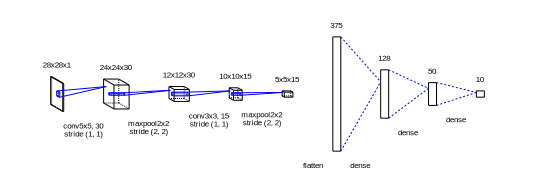

In [3]:
from IPython.display import SVG

# Model based on LeNet-5:
model = Model(input_shape=(28, 28, 1))
model.add(Conv2D(30, (5, 5), strides=(1, 1), padding="valid"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(15, (3, 3), padding="valid"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(50))
model.add(Dense(10))

# Save as svg file and display it:
model.save_fig("model.svg")
SVG("model.svg")